In [33]:
from utils import Data

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [34]:
import pickle
import pandas as pd 
import os
from scipy.stats import ttest_ind
import argparse
import numpy as np
from tqdm.notebook import tqdm

In [36]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--input_dir", 
    help="directory of input files", 
    type=str, 
    default="./data"
)
parser.add_argument(
    "--output_dir",
    help="directory of output files",
    type=str,
    default="./output",
)
parser.add_argument(
    "--runs",
    help="number of runs",
    type=int,
    default=10,
)
args = parser.parse_args([])

def generateTFactivity(tf, idx2can, tmr, cans, tf_name):
    # generate the TF activity matrix
    df_TF = pd.DataFrame(data = tf, columns = tf_name, index = tmr)
    can_names = [idx2can[idx] for idx in cans]
    df_TF["cancer_type"] = can_names
    return(df_TF)

#readin input dataset
data = pickle.load( open(os.path.join(args.input_dir,"dataset_CITRUS.pkl"), "rb"))

# read in output datasets of 10 runs
Ntf = args.runs
run = list()
# for i in range(1,Ntf+1):
for i in tqdm([1, 2, 3, 4, 5, 7]):
    args.output_dir = '/ix/hosmanbeyoglu/kor11/CITRUS_PKL/'
    # args.output_dir = '/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output'
    dataset = pickle.load( open(os.path.join(args.output_dir,"output_dataset_CITRUS_{}.pkl".format(i)), "rb"), )
    # dataset = pickle.load( open(os.path.join(args.output_dir,"outputx_dataset_CITRUS_{}mask33.pkl".format(i)), "rb"), )
    run.append(dataset) 

  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
tfs = list()
for i in range(len(run)):
    tfs.append(run[i]["hid_tmr"])

## genereate ensemble tf activity matrix
tf_ensemble = 0
for i in range(len(run)):
    tf_ensemble += tfs[i]
    
tf_ensemble = tf_ensemble/Ntf

df_tf = generateTFactivity(tf_ensemble, data["idx2can"],data["tmr"], data["can"], data["tf_name"])

len(tfs)

6

In [38]:
from scipy.stats import ttest_ind as ttest

In [39]:
df = pd.DataFrame(np.column_stack([data['tmr'], data['can']]), columns=['tmr', 'cancer'])
df['cancer'] = df['cancer'].astype(int).replace(data['idx2can'])

def split_mutants(cancer, gene):    
    _sm = f'SM_{gene}'
    _scna = f'SCNA_{gene}'
    
    dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
    
    wt = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 0)]
    sm = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 0)]
    scna = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 1)]
    sm_scna = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 1)]
    
    return wt.index.values, sm.index.values, scna.index.values, sm_scna.index.values

In [40]:
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

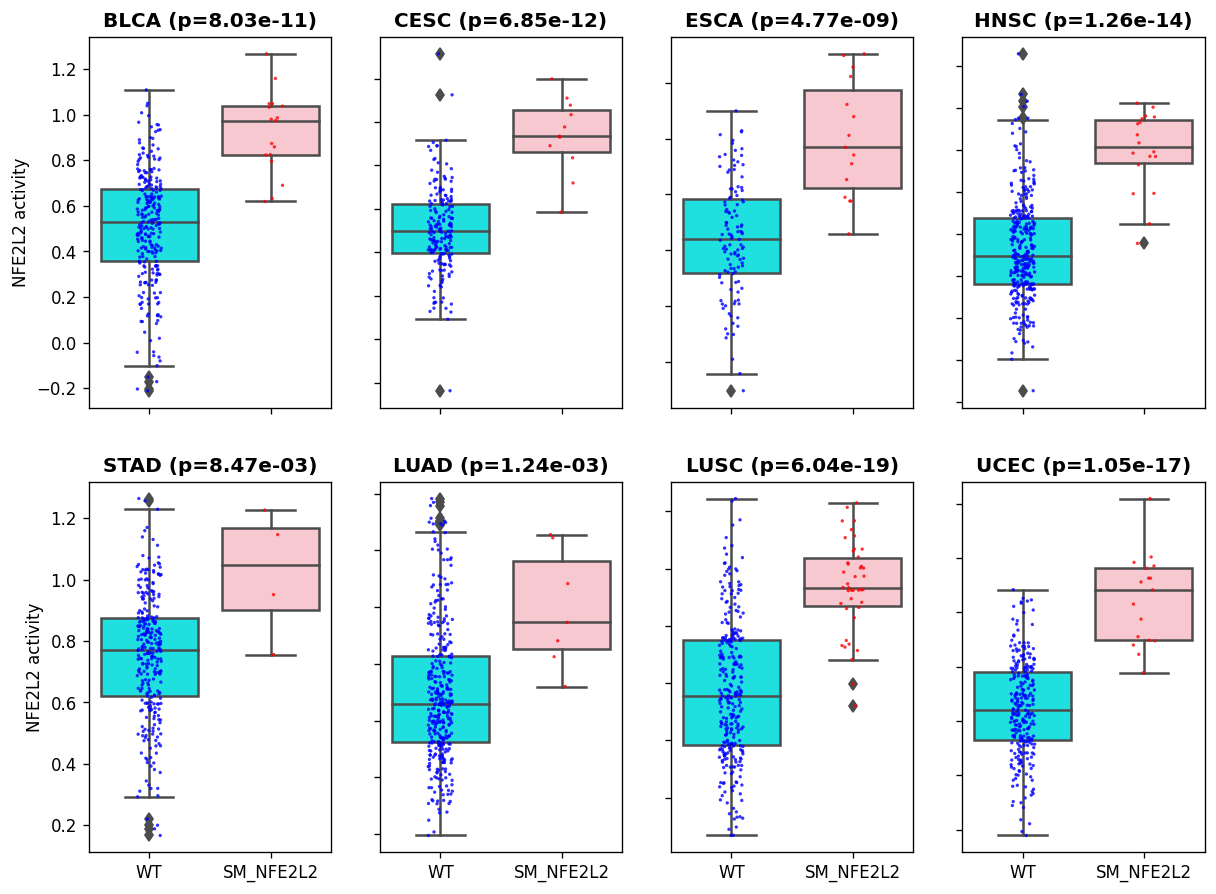

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'NFE2L2'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, _, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(sm).union(set(wt))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SM_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SM_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()

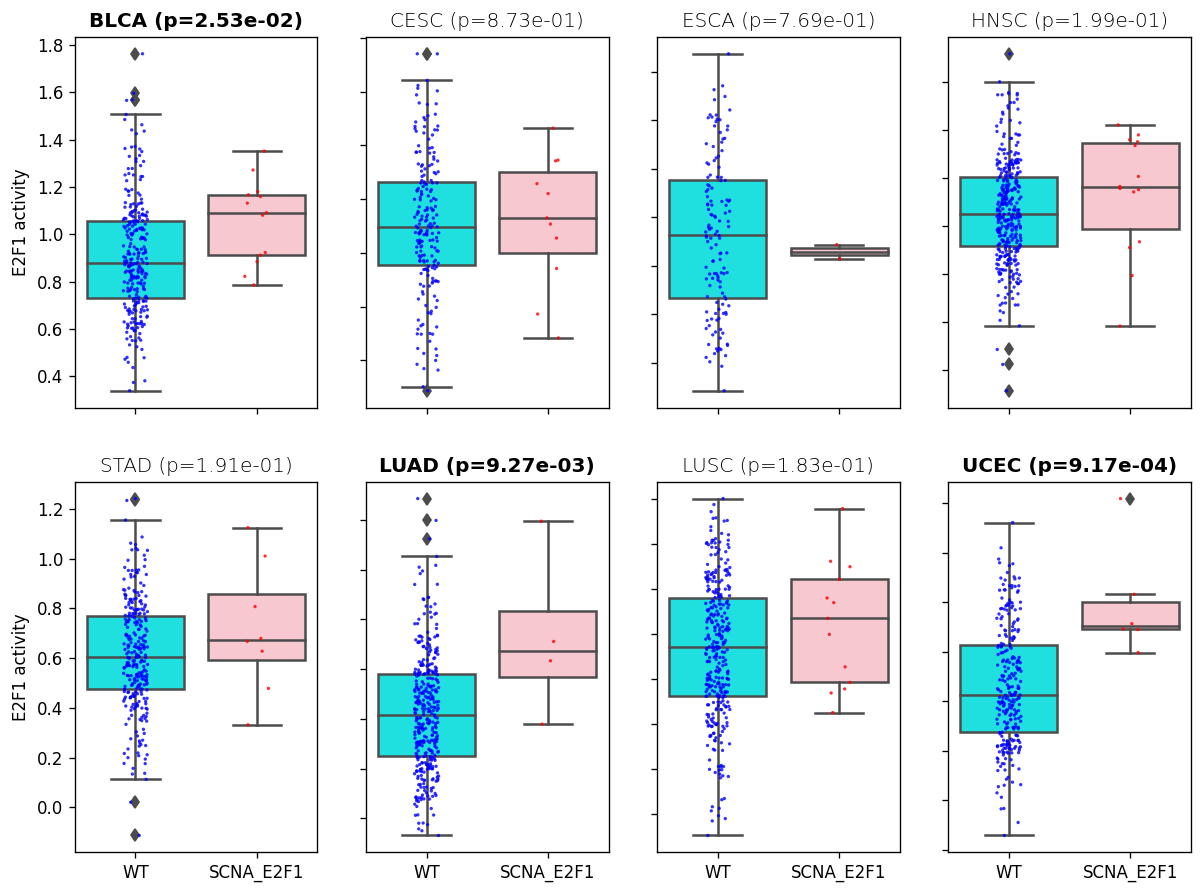

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'E2F1'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, scna, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(wt).union(set(scna))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SCNA_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SCNA_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()

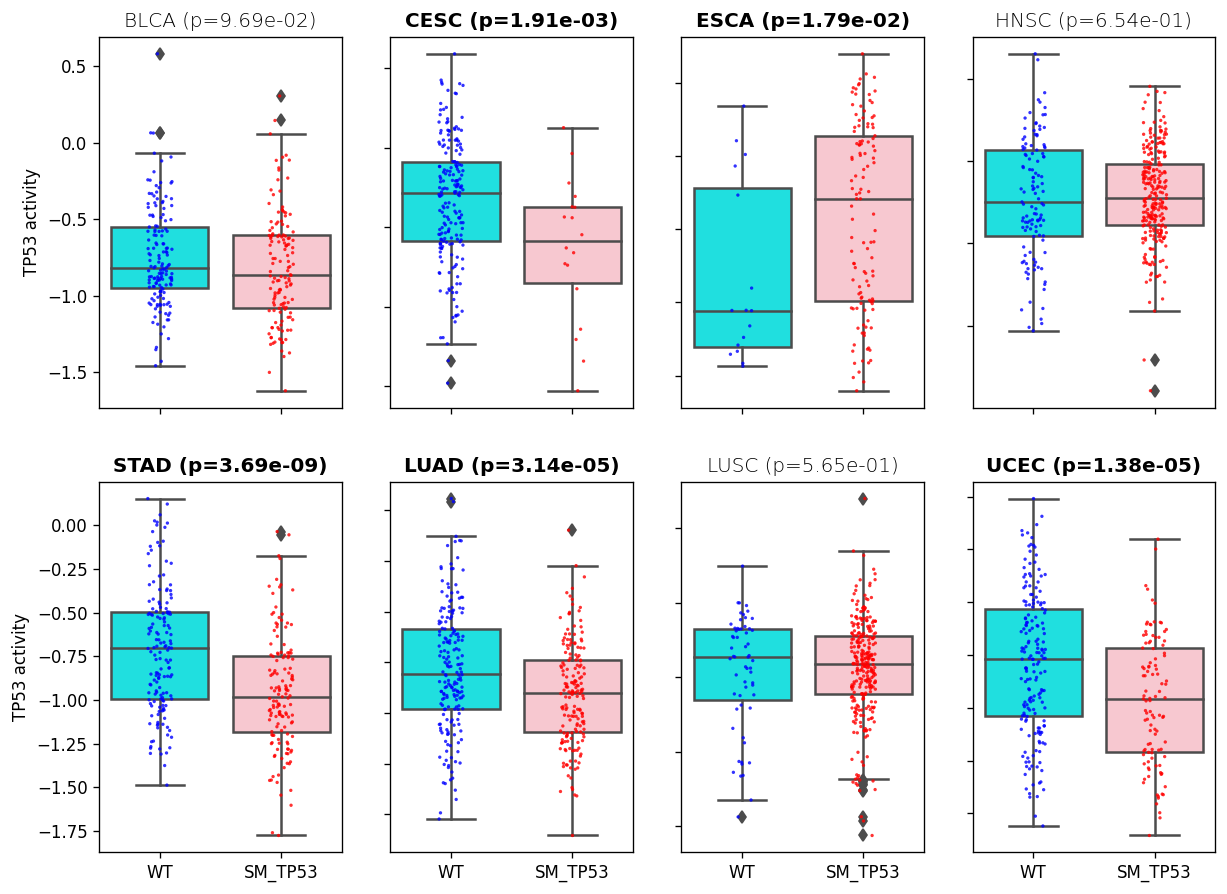

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'TP53'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, _, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(sm).union(set(wt))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SM_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SM_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()

In [41]:
import numpy as np
import pandas as pd

In [50]:
ppi_masks = np.load('ppi_masks.npy', allow_pickle=True)

xf = pd.DataFrame(ppi_masks[3], 
    index=np.load('index.npy', allow_pickle=True), 
    columns=np.load('columns.npy', allow_pickle=True))

print((xf.loc[:, (xf != 0).any(axis=0)]).loc[:, xf.loc[:, (xf != 0).any(axis=0)].sum(0) > 20].shape)

(xf.loc[:, (xf != 0).any(axis=0)]).loc[:, xf.loc[:, (xf != 0).any(axis=0)].sum(0) > 0].sum(0).sort_values(ascending=False)[:25]

(320, 67)


Generic Transcription Pathway                                                           155
Signaling by Interleukins                                                                84
Cellular Senescence                                                                      70
PIP3 activates AKT signaling                                                             70
SUMOylation                                                                              68
Toll-like Receptor Cascades                                                              59
ESR-mediated signaling                                                                   53
Signaling by NTRKs                                                                       52
GPCR downstream signalling                                                               47
Activation of anterior HOX genes in hindbrain development during early embryogenesis     47
Fc epsilon receptor (FCERI) signaling                                           

In [51]:
run[i]["pathways"].shape

(4642, 67)

In [52]:

pths = list()
for i in range(len(run)-3):
    pths.append(run[i]["pathways"])
    
## genereate ensemble tf activity matrix
pths_ensemble = 0
for i in range(len(run)-3):
    pths_ensemble += pths[i]
    
pths_ensemble = pths_ensemble/Ntf

def generateTFactivity(tf, idx2can, tmr, cans, tf_name):
    # generate the TF activity matrix
    df_TF = pd.DataFrame(data = tf, columns = tf_name, index = tmr)
    can_names = [idx2can[idx] for idx in cans]
    df_TF["cancer_type"] = can_names
    return(df_TF)

_pathways = np.load('_pathways.npy', allow_pickle=True)
pathways = (xf.loc[:, (xf != 0).any(axis=0)]).loc[:, xf.loc[:, (xf != 0).any(axis=0)].sum(0) > 20].columns
pth_tf = generateTFactivity(pths_ensemble, data["idx2can"],data["tmr"], data["can"], pathways)

len(pths)

3

In [56]:
wt, sm, _, _ = split_mutants('LUSC', 'NFE2L2')
a = pth_tf.loc[wt].values[:, :len(pathways)]
b = pth_tf.loc[sm].values[:, :len(pathways)]
a.shape, b.shape

((290, 67), (42, 67))

In [57]:
r = pd.DataFrame([ttest(a[:, j], b[:, j]).pvalue for j in range(len(pathways))], 
        index=pathways).sort_values(by=0)
r.columns = ['pvalue']
# r.loc['PI3K/AKT Signaling in Cancer']
r.sort_values(by='pvalue')[:25]

,pvalue
Cellular response to heat stress,7.066338e-11
SUMOylation,2.262383e-10
Signaling by ERBB2,8.037428e-10
Beta-catenin independent WNT signaling,1.209570e-09
Signaling by VEGF,8.006332e-06
Signaling by ROBO receptors,1.061446e-05
Signaling by NOTCH3,2.145109e-05
Class I MHC mediated antigen processing & presentation,6.768285e-05
DNA Double Strand Break Response,1.954354e-04
RHO GTPase Effectors,2.699730e-04


In [14]:
wt, sm, _, _ = split_mutants('HNSC', 'PIK3CA')
a = pth_tf.loc[wt].values[:, :len(pathways)]
b = pth_tf.loc[sm].values[:, :len(pathways)]
r = pd.DataFrame([ttest(a[:, j], b[:, j]).pvalue for j in range(len(pathways))], 
        index=pathways).sort_values(by=0)
r.columns = ['pvalue']
r.loc['PI3K/AKT Signaling in Cancer']
r.sort_values(by='pvalue')[:25]

,pvalue
Neutrophil degranulation,7.575393e-08
Cellular response to heat stress,7.315232e-06
Signal amplification,4.923249e-04
Signaling by NOTCH1,1.089159e-03
S Phase,2.133567e-03
Netrin-1 signaling,2.841064e-03
Costimulation by the CD28 family,5.114799e-03
Fcgamma receptor (FCGR) dependent phagocytosis,6.303275e-03
C-type lectin receptors (CLRs),6.957291e-03
Neurotransmitter receptors and postsynaptic signal transmission,1.480285e-02


In [8]:
pth_tf

NameError: name 'pth_tf' is not defined

In [1]:
from models import CITRUS
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations


parser.add_argument(
    "--embedding_size",
    help="embedding dimension of genes and tumors",
    type=int,
    default=512,
)
parser.add_argument(
    "--hidden_size", 
    help="hidden layer dimension of MLP decoder", 
    type=int, 
    default=400
)
parser.add_argument(
    "--attention_size", 
    help="size of attention parameter beta_j", 
    type=int, 
    default=256
)
parser.add_argument(
    "--attention_head", 
    help="number of attention heads", 
    type=int, 
    default=32
)
parser.add_argument(
    "--learning_rate", 
    help="learning rate for Adam", 
    type=float, 
    default=1e-3
)
parser.add_argument(
    "--max_iter", 
    help="maximum number of training iterations", 
    type=int, 
    default=1000
)
parser.add_argument(
    "--max_fscore",
    help="Max F1 score to early stop model from training",
    type=float,
    default=0.7
)
parser.add_argument(
    "--batch_size", 
    help="training batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_batch_size", 
    help="test batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_inc_size",
    help="increment interval size between log outputs",
    type=int,
    default=256
)
parser.add_argument(
    "--dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--input_dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--weight_decay", 
    help="coefficient of l2 regularizer", 
    type=float, 
    default=1e-5
)
parser.add_argument(
    "--activation",
    help="activation function used in hidden layer",
    type=str,
    default="tanh",
)
parser.add_argument(
    "--patience", 
    help="earlystopping patience", 
    type=int, 
    default=10
)
parser.add_argument(
    "--mask01",
    help="wether to ignore the float value and convert mask to 01",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--gep_normalization", 
    help="how to normalize gep", 
    type=str, 
    default="scaleRow"
)
parser.add_argument(
    "--attention",
    help="whether to use attention mechanism or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--cancer_type",
    help="whether to use cancer type or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--train_model",
    help="whether to train model or load model",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--dataset_name",
    help="the dataset name loaded and saved",
    type=str,
    default="dataset_CITRUS",
)
parser.add_argument(
    "--tag", 
    help="a tag passed from command line", 
    type=str, 
    default=""
)
parser.add_argument(
    "--run_count", 
    help="the count for training", 
    type=str, 
    default="1"
)

parser.add_argument(
    "--label", 
    help="model label", 
    type=str, 
    default="untitled"
)

parser.add_argument(
    "--ppi", 
    help="", 
    type=int, 
    default=0
)
args = parser.parse_args([])


NameError: name 'parser' is not defined

In [295]:

masks = np.load('./pnet_prostate_paper/train/maps.npy', allow_pickle=True)
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)
args.tf_gene = dataset["tf_gene"]

args.can_size = dataset["can"].max()  # cancer type dimension
args.sga_size = dataset["sga"].max()  # SGA dimension
args.gep_size = dataset["gep"].shape[1]  # GEP output dimension
args.num_max_sga = dataset["sga"].shape[1]  # maximum number of SGAs in a tumor

model = CITRUS(args, masks)  

In [297]:
import torch

model.load_state_dict(torch.load(f'/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/model_1_mask33.pth', 
                    map_location=torch.device('cpu')))
model.eval()

RuntimeError: Error(s) in loading state_dict for CITRUS:
	Unexpected key(s) in state_dict: "layer_sga_emb.weight", "layer_can_emb.weight", "pik_emb.weight", "layer_w_0.weight", "layer_w_0.bias", "layer_beta.weight", "layer_beta.bias", "layer_w_2.weight", "layer_w_2.bias", "pathways.weight", "pathways.bias", "layer_w_1.weight", "layer_w_1.bias". 